In [1]:
%matplotlib notebook
from PIL import Image #package is Pillow
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.image as mpimg

(600,)


<IPython.core.display.Javascript object>


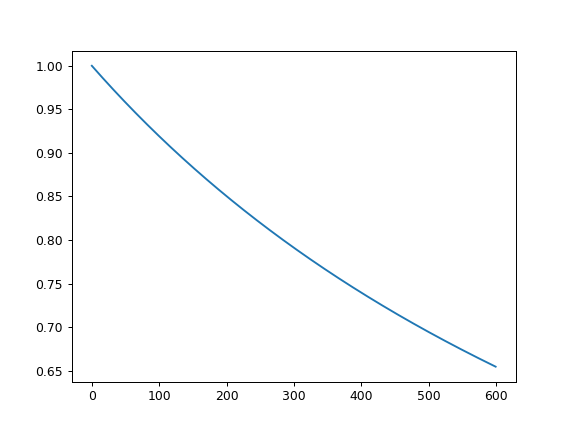

In [2]:
    nr_of_colors = 600
    height = 100

    #standard rainbow
    # source https://www.instructables.com/id/How-to-Make-Proper-Rainbow-and-Random-Colors-With-/

    one_fifth_of_colors = nr_of_colors/5

    data = np.zeros((height, nr_of_colors, 3), dtype=np.uint8)
    for kk in range(int(one_fifth_of_colors)):
        data[:, kk] = [255, int(255*kk/one_fifth_of_colors), 0]

    for kk in range(int(one_fifth_of_colors)):
        data[:, kk+int(one_fifth_of_colors) ] = [255-int(255*kk/one_fifth_of_colors),255, 0]

    for kk in range(int(one_fifth_of_colors)):
        data[:, kk+2*int(one_fifth_of_colors) ] = [0, 255, int(255*kk/one_fifth_of_colors)]

    for kk in range(int(one_fifth_of_colors)):
        data[:, kk+3*int(one_fifth_of_colors) ] = [0, 255-int(255*kk/one_fifth_of_colors),255]

    for kk in range(int(one_fifth_of_colors)):
        data[:, kk+4*int(one_fifth_of_colors) ] = [int(255*kk/one_fifth_of_colors), 0,255]


    img = Image.fromarray(data, 'RGB')
    img.save('Rainbow.png')
    img.show()

    rgb_data = np.array(data[0,:,:])

    lambda_min = 300
    lambda_max = 700
    nr_of_values = nr_of_colors    

    freqweight = 1/np.linspace(start = 1/np.sqrt(lambda_max), stop=1/np.sqrt(lambda_min), num = nr_of_values)
    #freqweight = np.ones(nr_of_colors) #use this for a flat weighting = 'white noise'
    freqweight /= freqweight[0]

    print(freqweight.shape)
    rgb_data[:,0] = rgb_data[:,0] * freqweight
    rgb_data[:,1] = rgb_data[:,1] * freqweight
    rgb_data[:,2] = rgb_data[:,2] * freqweight

    weighted_data = np.zeros((height, nr_of_colors, 3), dtype=np.uint8)

    for kk in range(height):
        weighted_data[kk,:,:] = rgb_data

    # plot results
   
    fig, ax = pyplot.subplots()
    ax.plot(freqweight)
    fig.show()
    img2 = Image.fromarray(weighted_data, 'RGB')
    img2.save('RainbowwithWeighting.png')
    img2.show()

<IPython.core.display.Javascript object>


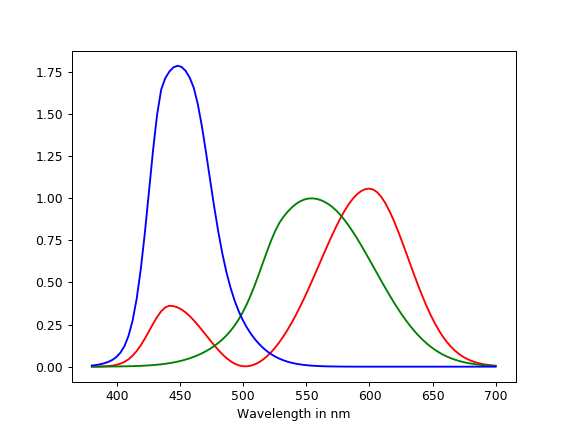

[Text(0.5, 0, 'Wavelength in nm')]

In [3]:
def CIE_xyzValues(wavelen):
    """ Returns the corresponding CIE values for a given wavelength lambda in nm. 
    
    The values are not from the standardized tabular from 1931, but from an approximation function, published in 
        Wyman, C., Sloan, P. P., & Shirley, P. (2013). Simple analytic approximations to the CIE XYZ color matching functions. Journal of Computer Graphics Techniques, 2(2), 1-11.
    
    param: wavelength in nm (typical values are from 380 to 700 nm (visile light from pink to red))
    return, triple of x,y,z values of the CIE standard
    
    License: (Original paper CC-BY with c-function). Here BSD 3-clause
    Author: J. Bitzer
    Version 1.0, August 2017
    """
    

    if wavelen < 442.0:
        t1 = (wavelen-442.0)*0.0624
    else:    
        t1 = (wavelen-442.0)*0.0374

    if wavelen<599.8:
        t2 = (wavelen-599.8)*0.0264
    else:
        t2 = (wavelen-599.8)*0.0323

    if wavelen < 501.1:
        t3 = (wavelen-501.1)*0.0490
    else:
        t3 = (wavelen-501.1)*0.0382

    Out_x = 0.362*np.exp(-0.5*t1*t1) + 1.056*np.exp(-0.5*t2*t2)- 0.065*np.exp(-0.5*t3*t3)

    if wavelen < 568.8:
        t1 = (wavelen-568.8)*0.0213
    else:    
        t1 = (wavelen-568.8)*0.0247

    if wavelen<530.9:
        t2 = (wavelen-530.9)*0.0613
    else:
        t2 = (wavelen-530.9)*0.0322
        
    
    Out_y =  0.821*np.exp(-0.5*t1*t1) + 0.286*np.exp(-0.5*t2*t2)
    
    if wavelen < 437.0:
        t1 = (wavelen-437.0)*0.0845
    else:    
        t1 = (wavelen-437.0)*0.0278

    if wavelen<459.0:
        t2 = (wavelen-459.0)*0.0385
    else:
        t2 = (wavelen-459.0)*0.0725
        
    
    Out_z =  1.217*np.exp(-0.5*t1*t1) + 0.681*np.exp(-0.5*t2*t2)
    
    return Out_x,Out_y,Out_z
    
    
def CIE_normalize_xyz(x,y,z):
    """a simple normalization of 3 values by the sum of the tree values
    License: public domain (to simple to justify copyrights)"""
    normval = x+y+z;
    return x/normval,y/normval,z/normval, normval


nr_of_values = 100    
wavelen_v = np.linspace(start = 380, stop=700, num = nr_of_values)
outx = np.zeros(nr_of_values)
outy = np.zeros(nr_of_values)
outz = np.zeros(nr_of_values)

for kk in range(nr_of_values):
    outx[kk],outy[kk],outz[kk] = CIE_xyzValues(wavelen_v[kk])

fig, ax = pyplot.subplots()
ax.plot(wavelen_v,outx, 'r') 
ax.plot(wavelen_v,outy, 'g') 
ax.plot(wavelen_v,outz, 'b') 
ax.set(xlabel='Wavelength in nm')


In [4]:
def xyz_to_rgb(XYZ,color_system = 'EBU', white_def = 'E'):
# from http://www.fourmilab.ch/documents/specrend/specrend.c
    IlluminantD65 = [0.3127,0.3291]
    IlluminantC   = [0.3101, 0.3162]
    IlluminantE   = [0.33333333, 0.33333333]
    
    if color_system == 'EBU':
        red = [0.64, 0.33]
        green = [0.29, 0.60]
        blue = [0.15, 0.06]
    elif color_system == 'NTSC':
        red = [0.67, 0.33]
        green = [0.21, 0.71]
        blue = [0.14, 0.08]
    elif color_system == 'SMPTE':
        red = [0.63, 0.34]
        green = [0.31, 0.595]
        blue = [0.155, 0.07]
    elif color_system == 'CIE':
        red = [0.7355, 0.2645]
        green = [0.2658, 0.7243]
        blue = [0.1669, 0.0085]
    elif color_system == 'CIE709':
        red = [0.64, 0.33]
        green = [0.3, 0.6]
        blue = [0.15, 0.06]

# idea from https://scipython.com/blog/converting-a-spectrum-to-a-colour/

    color_mat = np.array([(red[0], green[0], blue[0]), (red[1], green[1],blue[1]), (1-red[0]-red[1], 1-green[0]-green[1],1-blue[0]-blue[1])])
    
    inv_color_mat = np.linalg.inv(color_mat)

    #scaling to white
    if white_def == 'D65':
        white_scale = np.array((IlluminantD65[0], IlluminantD65[1], 1 - IlluminantD65[0]- IlluminantD65[1]))
    elif white_def == 'C':
        white_scale = np.array((IlluminantC[0], IlluminantC[1], 1 - IlluminantC[0]- IlluminantC[1]))
    elif white_def == 'E':
        white_scale = np.array((IlluminantE[0], IlluminantE[1], 1 - IlluminantE[0]- IlluminantE[1]))
    
    white_scale = inv_color_mat.dot(white_scale)
    
    final_rgb_mat = inv_color_mat / white_scale[:, np.newaxis]
 
    rgb = final_rgb_mat.dot(XYZ)
    
    return rgb


def constrain_rgb(rgb, mode = 0):
    
    if mode == 0:
        minval = min([0, min(rgb)])
        rgb -= minval
    else:
        if rgb[0] < 0:
            rgb[0] = 0
        if rgb[1] < 0:
            rgb[1] = 0
        if rgb[2] < 0:
            rgb[2] = 0
    
    return rgb

def normalize_rgb(rgb):
    maxval = max([1 ,max(rgb)])
    #maxval = max(rgb)
    rgb /= maxval
    return rgb

def gamma_correcion_rgb(rgb):
        cc = 0.018;
        out = np.zeros(len(rgb))
        for kk,val in enumerate(rgb):
            if (val < cc): 
                val *= (1.099 * val**0.45 - 0.099) / cc
            else:
                val = (1.099 * val** 0.45) - 0.099
                
            out[kk] = val
        return out


In [5]:
nr_of_freqs = nr_of_colors
wavelen_all = np.linspace(start = 380,stop = 700, num = nr_of_freqs)

freqweight = freqweight[::-1]


X_fullspectrum = 0.0;
Y_fullspectrum = 0.0;
Z_fullspectrum = 0.0;


for kk,wavelen in enumerate(wavelen_all):
    x,y,z = CIE_xyzValues(wavelen)
    X_fullspectrum += x*freqweight[kk]
    Y_fullspectrum += y*freqweight[kk]
    Z_fullspectrum += z*freqweight[kk]

    XYZ_Norm = X_fullspectrum + Y_fullspectrum + Z_fullspectrum
    
    x_final = X_fullspectrum/XYZ_Norm
    y_final = Y_fullspectrum/XYZ_Norm
    z_final = Z_fullspectrum/XYZ_Norm


rgbout = xyz_to_rgb([x_final,y_final,z_final],'EBU')
rgbout = constrain_rgb(rgbout,1)
max_val = np.max(rgbout)
rgbout /= max_val;
rgbout = gamma_correcion_rgb(rgbout)
print(rgbout)

height = 200
weighted_data = np.zeros((height, height, 3), dtype=np.uint8)

for kk in range(height):
    weighted_data[kk,:,:] = 255*rgbout

# plot results
   
img2 = Image.fromarray(weighted_data, 'RGB')
img2.save('FinalColorOneOverFreq.png')
img2.show()



[1.         0.94605317 0.8830502 ]
